In [195]:
import pandas as pd;
import numpy as np;
import scipy as sp;
import sklearn;
import sys;
from nltk.corpus import stopwords;
import nltk;
from gensim.models import ldamodel
import gensim.corpora;
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
from sklearn.decomposition import TruncatedSVD
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim
import pickle;

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [78]:
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import random 
random.seed(13)

#visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import seaborn as sns


In [3]:
import csv
import re
#import spacy
import sys
import requests
import pandas as pd
from io import StringIO
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFTextExtractionNotAllowed
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfdevice import PDFDevice
import os
import sys, getopt
import numpy as np
from bs4 import BeautifulSoup
import urllib3
from glob import glob
from string import punctuation

from nltk.corpus import wordnet

def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

def find_pdfs():
    list_of_pdfs = []
    list_of_pdfs += glob(os.path.join('./LosPositasSyllabi',"*.{}".format('pdf')))
    list_of_pdfs += glob(os.path.join('./LosPositasSyllabi2',"*.{}".format('pdf')))
    list_of_pdfs += glob(os.path.join('./LosPositasSyllabi3',"*.{}".format('pdf')))
    list_of_pdfs += glob(os.path.join('./LosPositasSyllabi4',"*.{}".format('pdf')))
    list_of_pdfs += glob(os.path.join('./AllSyllabiParser',"*.{}".format('pdf')))
    return list_of_pdfs

def convert(fname, pages=None):
    """ Function converting pdf to string """
    if not pages:
        pagenums = set()
    else:
        pagenums = set(pages)

    output = StringIO()
    manager = PDFResourceManager()
    converter = TextConverter(manager, output, laparams=LAParams())
    interpreter = PDFPageInterpreter(manager, converter)

    infile = open(fname, 'rb')
    
    try:
        for page in PDFPage.get_pages(infile, pagenums):
            interpreter.process_page(page)
    except PDFTextExtractionNotAllowed:
        print('This pdf won\'t allow text extraction!')
    infile.close()
    converter.close()
    text = output.getvalue()
    output.close
    return strip_punctuation(text)

def word_count(string):
    my_string = string.lower().split()
    my_dict = {}
    for item in my_string:
        if item in my_dict:
            my_dict[item] += 1
        else:
            my_dict[item] = 1
    


In [4]:
list_of_pdfs = find_pdfs()
syllabus_string = ''
bag_of_words_all_syllabi = []
corpus = []
#Converting pdf to string
for pdf in list_of_pdfs:
    syllabus_string = convert(pdf)
    corpus.append(syllabus_string)
#     bag_of_words_one_syllabus = word_count(syllabus_string)
#     bag_of_words_all_syllabi.append(bag_of_words_one_syllabus)

This pdf won't allow text extraction!
This pdf won't allow text extraction!


**Text Cleaning**

In [5]:
from nltk.corpus import words
from nltk.corpus import stopwords
 

allEnglishWords = set(words.words())
stopwordsList = set(stopwords.words('english'))

def clean_doc(doc, english = False, return_list = False, stopwords = False):
    listOfWords = re.findall(r'[^\d\W]{2,}', doc)
    listOfWords = [word.lower() for word in listOfWords]
    if english:
        listOfWords = [word for word in listOfWords if word in allEnglishWords]
    if stopwords:
        listOfWords = [word for word in listOfWords if word not in stopwordsList]
    if return_list:
        return listOfWords
    else:
        return " ".join(listOfWords)


In [6]:
cleaned_corpus = [clean_doc(doc, return_list = True, stopwords = True) for doc in corpus]

In [7]:
cleaned_corpus_1 = [clean_doc(doc, english = True, return_list = True, stopwords = True) for doc in corpus]

In [8]:
cleaned_corpus_2 = [clean_doc(doc, english = True, return_list = False, stopwords = True) for doc in corpus]

In [9]:
cleaned_corpus_3 = [clean_doc(doc, english = False, return_list = False, stopwords = True) for doc in corpus]

In [10]:
cleaned_corpus_4 = [clean_doc(doc, english = False, return_list = True, stopwords = True) for doc in corpus]

**NMF**

In [11]:
vectorizer = CountVectorizer(analyzer='word', stop_words='english', lowercase=True, token_pattern=r'[^\d\W]{2,}');
x_counts = vectorizer.fit_transform(cleaned_corpus_2);

In [13]:
id2word = {}
for i, word in enumerate(words):
    id2word[i] = word

In [14]:
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

In [15]:
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [128]:
def get_nmf_topics(model, num_topics, top_n_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-top_n_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [219]:
num_topics = 40
nmf_model = NMF(n_components=num_topics, init='nndsvd')
nmf_model.fit(xtfidf_norm)

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
  max_iter=200, n_components=40, random_state=None, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [180]:
get_nmf_topics(nmf_model, num_topics,5)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20,Topic # 21,Topic # 22,Topic # 23,Topic # 24,Topic # 25,Topic # 26,Topic # 27,Topic # 28,Topic # 29,Topic # 30,Topic # 31,Topic # 32,Topic # 33,Topic # 34,Topic # 35,Topic # 36,Topic # 37,Topic # 38,Topic # 39,Topic # 40,Topic # 41,Topic # 42,Topic # 43,Topic # 44,Topic # 45,Topic # 46,Topic # 47,Topic # 48,Topic # 49,Topic # 50,Topic # 51,Topic # 52,Topic # 53,Topic # 54,Topic # 55,Topic # 56,Topic # 57,Topic # 58,Topic # 59,Topic # 60,Topic # 61,Topic # 62,Topic # 63,Topic # 64,Topic # 65,Topic # 66,Topic # 67,Topic # 68,Topic # 69,Topic # 70,Topic # 71,Topic # 72,Topic # 73,Topic # 74,Topic # 75,Topic # 76,Topic # 77,Topic # 78,Topic # 79,Topic # 80,Topic # 81,Topic # 82,Topic # 83,Topic # 84,Topic # 85,Topic # 86,Topic # 87,Topic # 88,Topic # 89,Topic # 90,Topic # 91,Topic # 92,Topic # 93,Topic # 94,Topic # 95,Topic # 96,Topic # 97,Topic # 98,Topic # 99,Topic # 100
0,business,soccer,welding,dance,missing,independent,training,exponential,musical,basketball,digital,network,wine,swimming,painting,exercise,flag,yoga,automotive,badminton,childhood,design,experience,criminal,plant,grammar,bowling,fencing,indoor,math,polo,ceremony,baton,volleyball,lighting,jazz,child,ultimate,accounting,communication,web,cisco,safety,theater,intercollegiate,color,sports,piano,drawing,geologic,library,medical,health,configure,film,energy,gun,lesson,acting,guitar,longer,judo,walking,art,engineering,sexual,newspaper,landscape,drug,vineyard,biology,softball,linear,juvenile,tae,winery,photography,public,writing,excel,statistics,relaxation,transistor,operating,user,language,logic,political,golf,floral,arrest,radio,management,cloud,music,television,psychology,leadership,fiction,alphabetic
1,marketing,play,arc,ballet,outline,project,weight,logarithmic,theater,game,image,security,grape,swim,studio,fitness,football,yo,diagnostic,backhand,early,interior,work,crime,garden,verb,game,footwork,climbing,algebra,water,anthology,deletion,team,light,literature,development,forehand,cash,interpersonal,site,routing,protection,production,competition,hue,sport,teaching,figure,geology,search,patient,safety,server,cinema,physics,rifle,choking,character,classic,taught,martial,fitness,works,optical,gender,story,construction,pharmacy,irrigation,laboratory,batting,solve,justice,federation,wine,photographic,marketing,reading,word,probability,strength,missing,disk,define,culture,control,social,ball,design,detention,station,project,storage,musical,studio,mental,government,craft,filing
2,market,outdoor,cutting,movement,course,study,strength,rational,duet,shooting,camera,wireless,tasting,backstroke,color,endurance,catching,breathing,engine,singles,curriculum,client,supervisor,justice,horticulture,past,step,blade,rock,learning,offense,literary,weapon,serve,design,ensemble,family,backhand,payroll,conflict,page,configuration,emergency,theatrical,team,colors,athletic,intermediate,composition,earth,bibliography,word,care,directory,narrative,motion,patrol,adult,scene,music,course,jujitsu,attire,architecture,optics,sexuality,journalism,site,pharmacology,soil,cell,slow,math,delinquency,proper,cellar,century,advertising,sentence,office,data,flexibility,power,hardware,data,sign,loop,economic,fairway,arrangement,deletion,broadcast,case,infrastructure,singing,production,abnormal,gavel,writing,keyboard
3,customer,heading,metal,choreographic,interactive,end,aerobic,quadratic,solo,dribble,photographic,configuration,sensory,stroke,acrylic,muscular,game,relaxation,diagnosis,forehand,developmentally,create,career,law,propagation,tense,spare,bout,interior,study,swim,magazine,legal,offense,residential,performance,developmental,game,financial,group,flash,switching,construction,technical,athletics,value,selected,chord,charcoal,dating,citation,surgical,nutrition,install,music,electric,of

In [220]:
nmf_embedding = nmf_model.transform(xtfidf_norm)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

**Visualize using T-SNE**

In [228]:
tsne = TSNE(random_state=3211)
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1)

In [223]:
def center(points, d = 2):
    if len(points) == 0: return None
    elif d==2:
        return (sum([x[0] for x in points])/len(points), sum([x[1] for x in points])/len(points))
    elif d==3:
        return (sum([x[0] for x in points])/len(points), sum([x[1] for x in points])/len(points), sum([x[2] for x in points])/len(points))

In [229]:
tsne_groups = [[] for x in range(num_topics)] 
for i in range(len(tsne_embedding)):
    tsne_groups[tsne_embedding['hue'][i]].append((tsne_embedding['x'][i],tsne_embedding['y'][i]))
tsne_centers = [center(points) for points in tsne_groups]

In [230]:
topic_words = [None]*num_topics
wordsDf = get_nmf_topics(nmf_model, num_topics,5)
for i in range(num_topics):
    topic_words[i] = ' '.join(wordsDf.iloc[0:3, i])
topic_words

['grammar writing reading',
 'soccer play outdoor',
 'welding arc cutting',
 'dance ballet movement',
 'missing outline course',
 'independent project study',
 'fitness exercise training',
 'linear solve exponential',
 'theater musical acting',
 'basketball intercollegiate game',
 'web site page',
 'network cisco configure',
 'wine winery grape',
 'swimming swim backstroke',
 'painting color studio',
 'music guitar piano',
 'flag football game',
 'yoga relaxation breathing',
 'automotive diagnostic engine',
 'badminton backhand singles',
 'child childhood early',
 'design drawing engineering',
 'experience work career',
 'criminal justice crime',
 'plant landscape soil',
 'health medical safety',
 'polo water offense',
 'art research social',
 'fencing footwork blade',
 'math algebra learning',
 'volleyball team kin',
 'production ceremony anthology',
 'baton weapon deletion',
 'communication group interpersonal',
 'lighting theater light',
 'jazz literature ensemble',
 'data operating

<IPython.core.display.Javascript object>


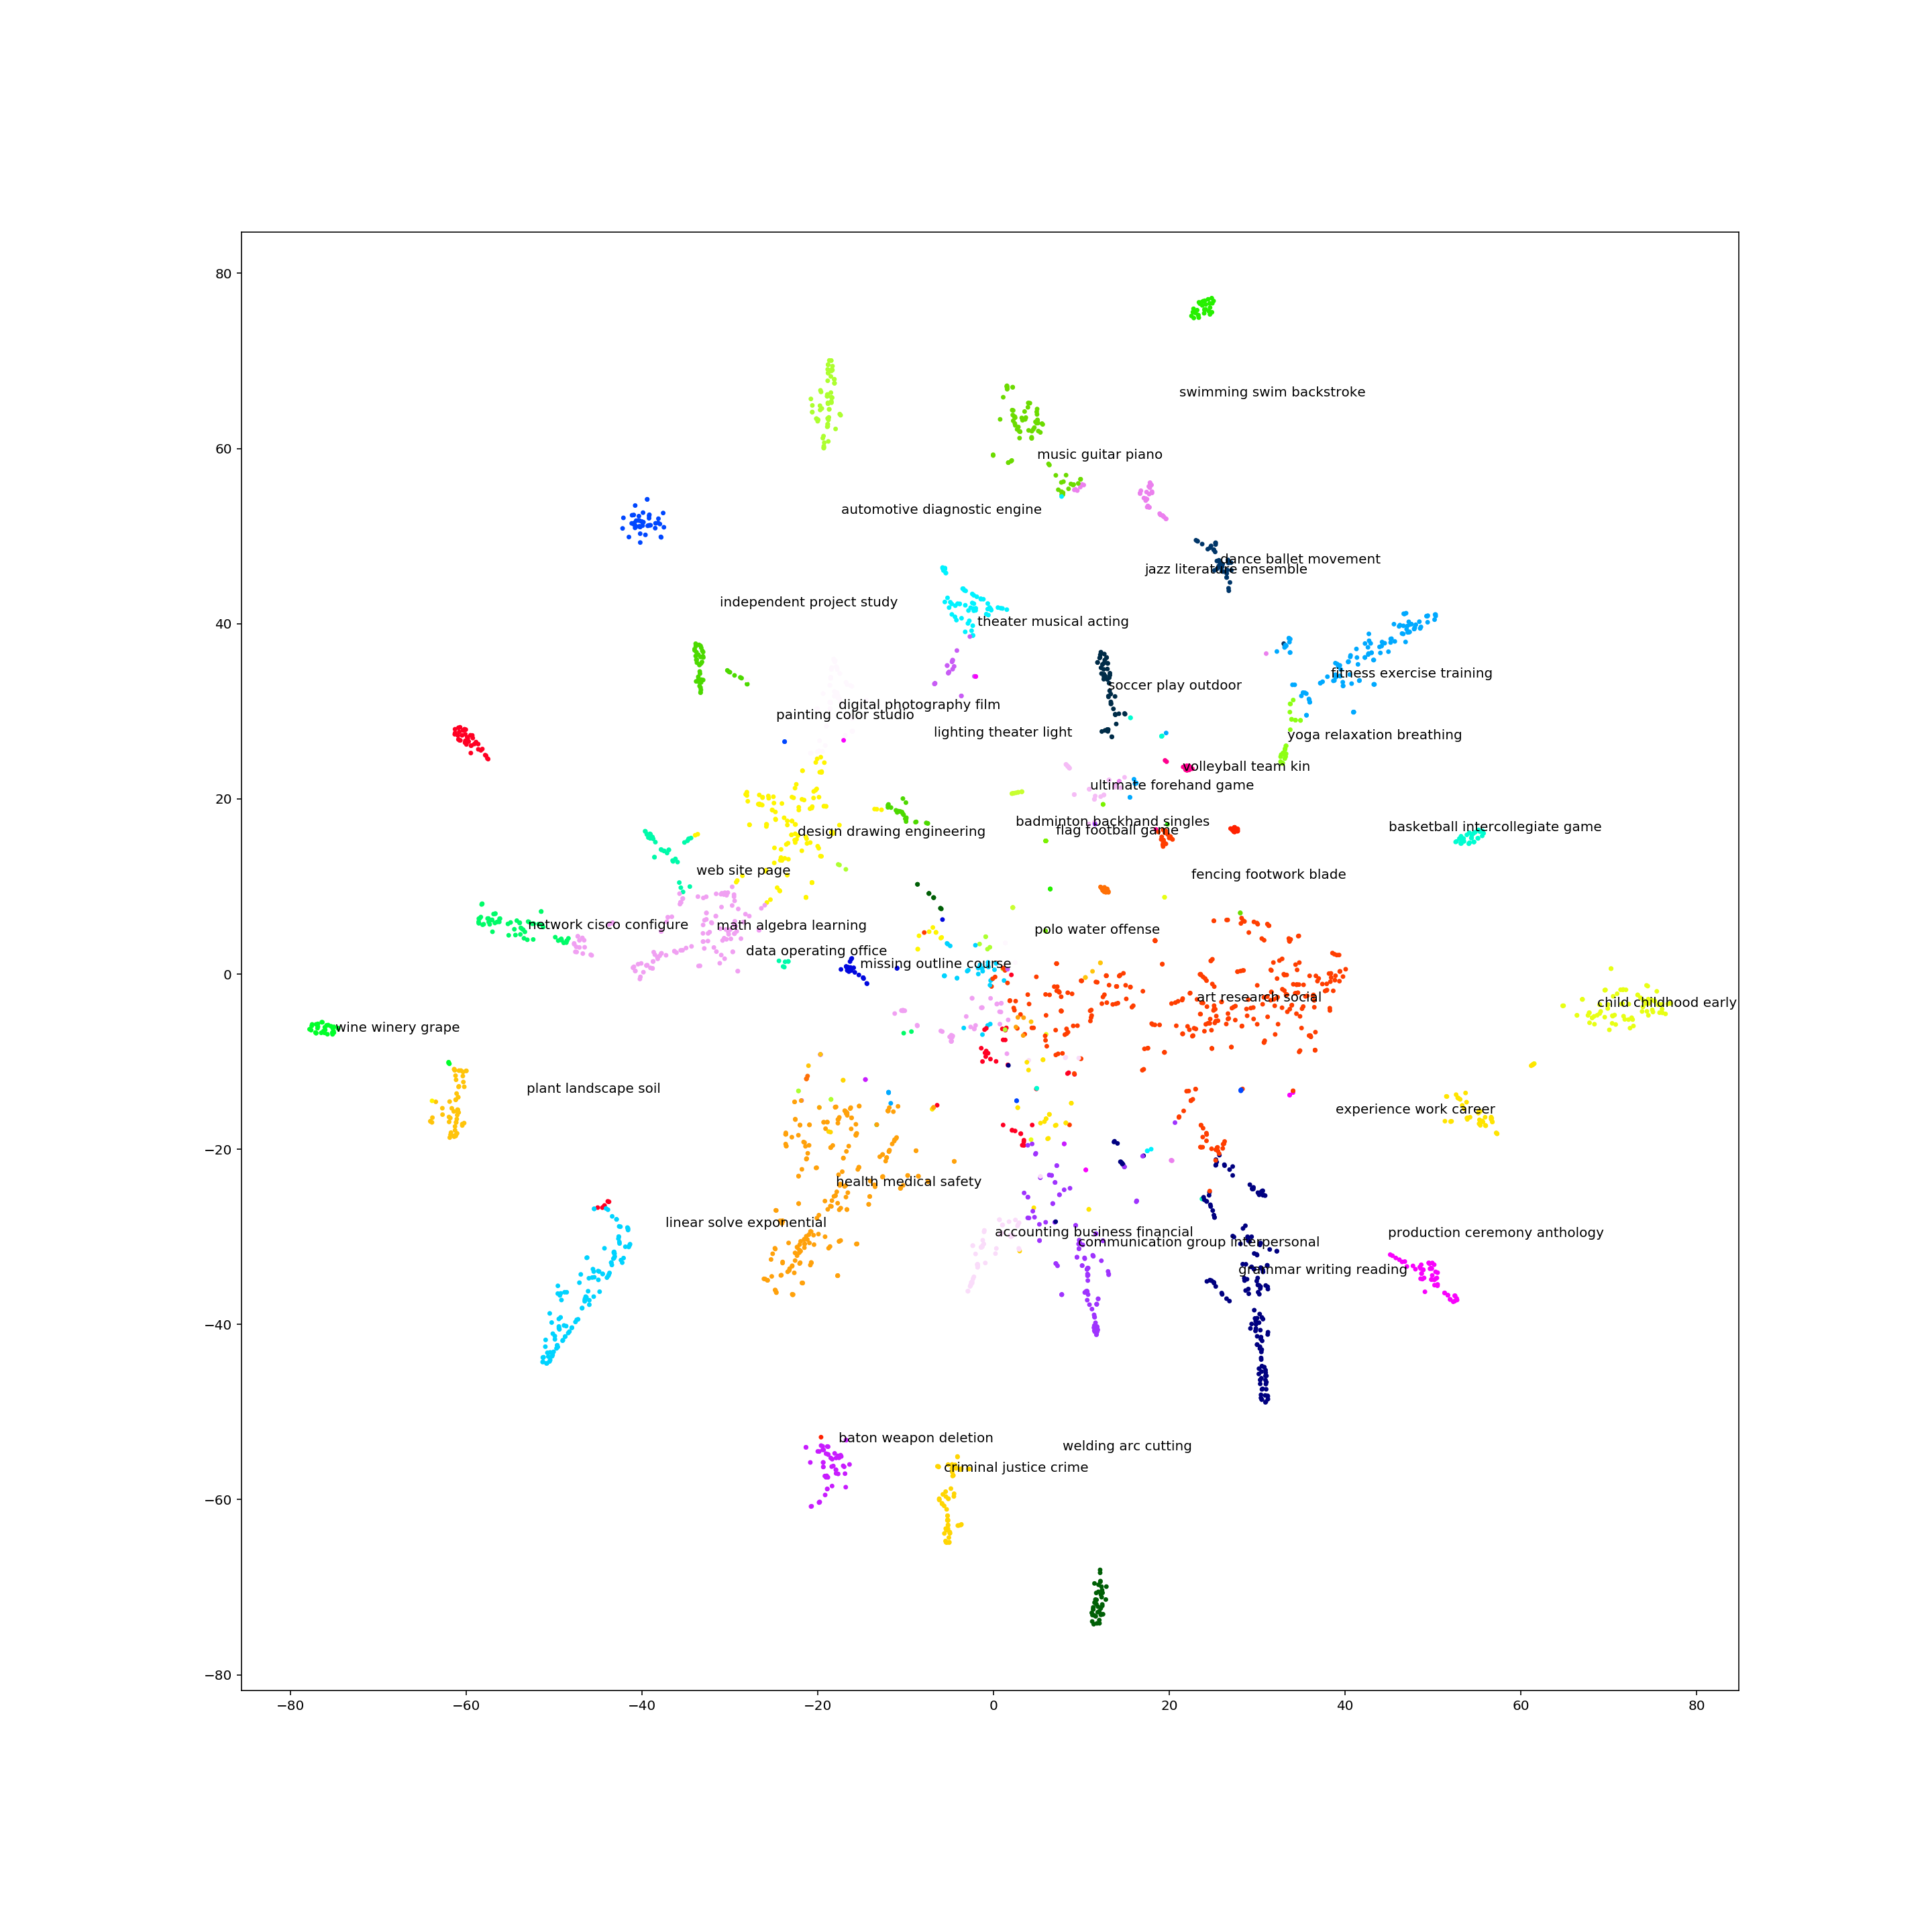

In [232]:
fig = plt.figure(figsize=(20, 20))
data = tsne_embedding
scatter = plt.scatter(data=data,x='x',y='y',s=6,c=data['hue'],cmap="gist_ncar")
for i, words in enumerate(topic_words):
    plt.annotate(words, (tsne_centers[i][0], tsne_centers[i][1]))
plt.show()

In [221]:
tsne = TSNE(n_components=3, random_state=3211)
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y','z'])
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1)


In [225]:
tsne_groups = [[] for x in range(num_topics)] 
for i in range(len(tsne_embedding)):
    tsne_groups[tsne_embedding['hue'][i]].append((tsne_embedding['x'][i],tsne_embedding['y'][i],tsne_embedding['z'][i]))
tsne_centers = [center(points, d=3) for points in tsne_groups]
topic_numbers = list(range(num_topics))

<IPython.core.display.Javascript object>


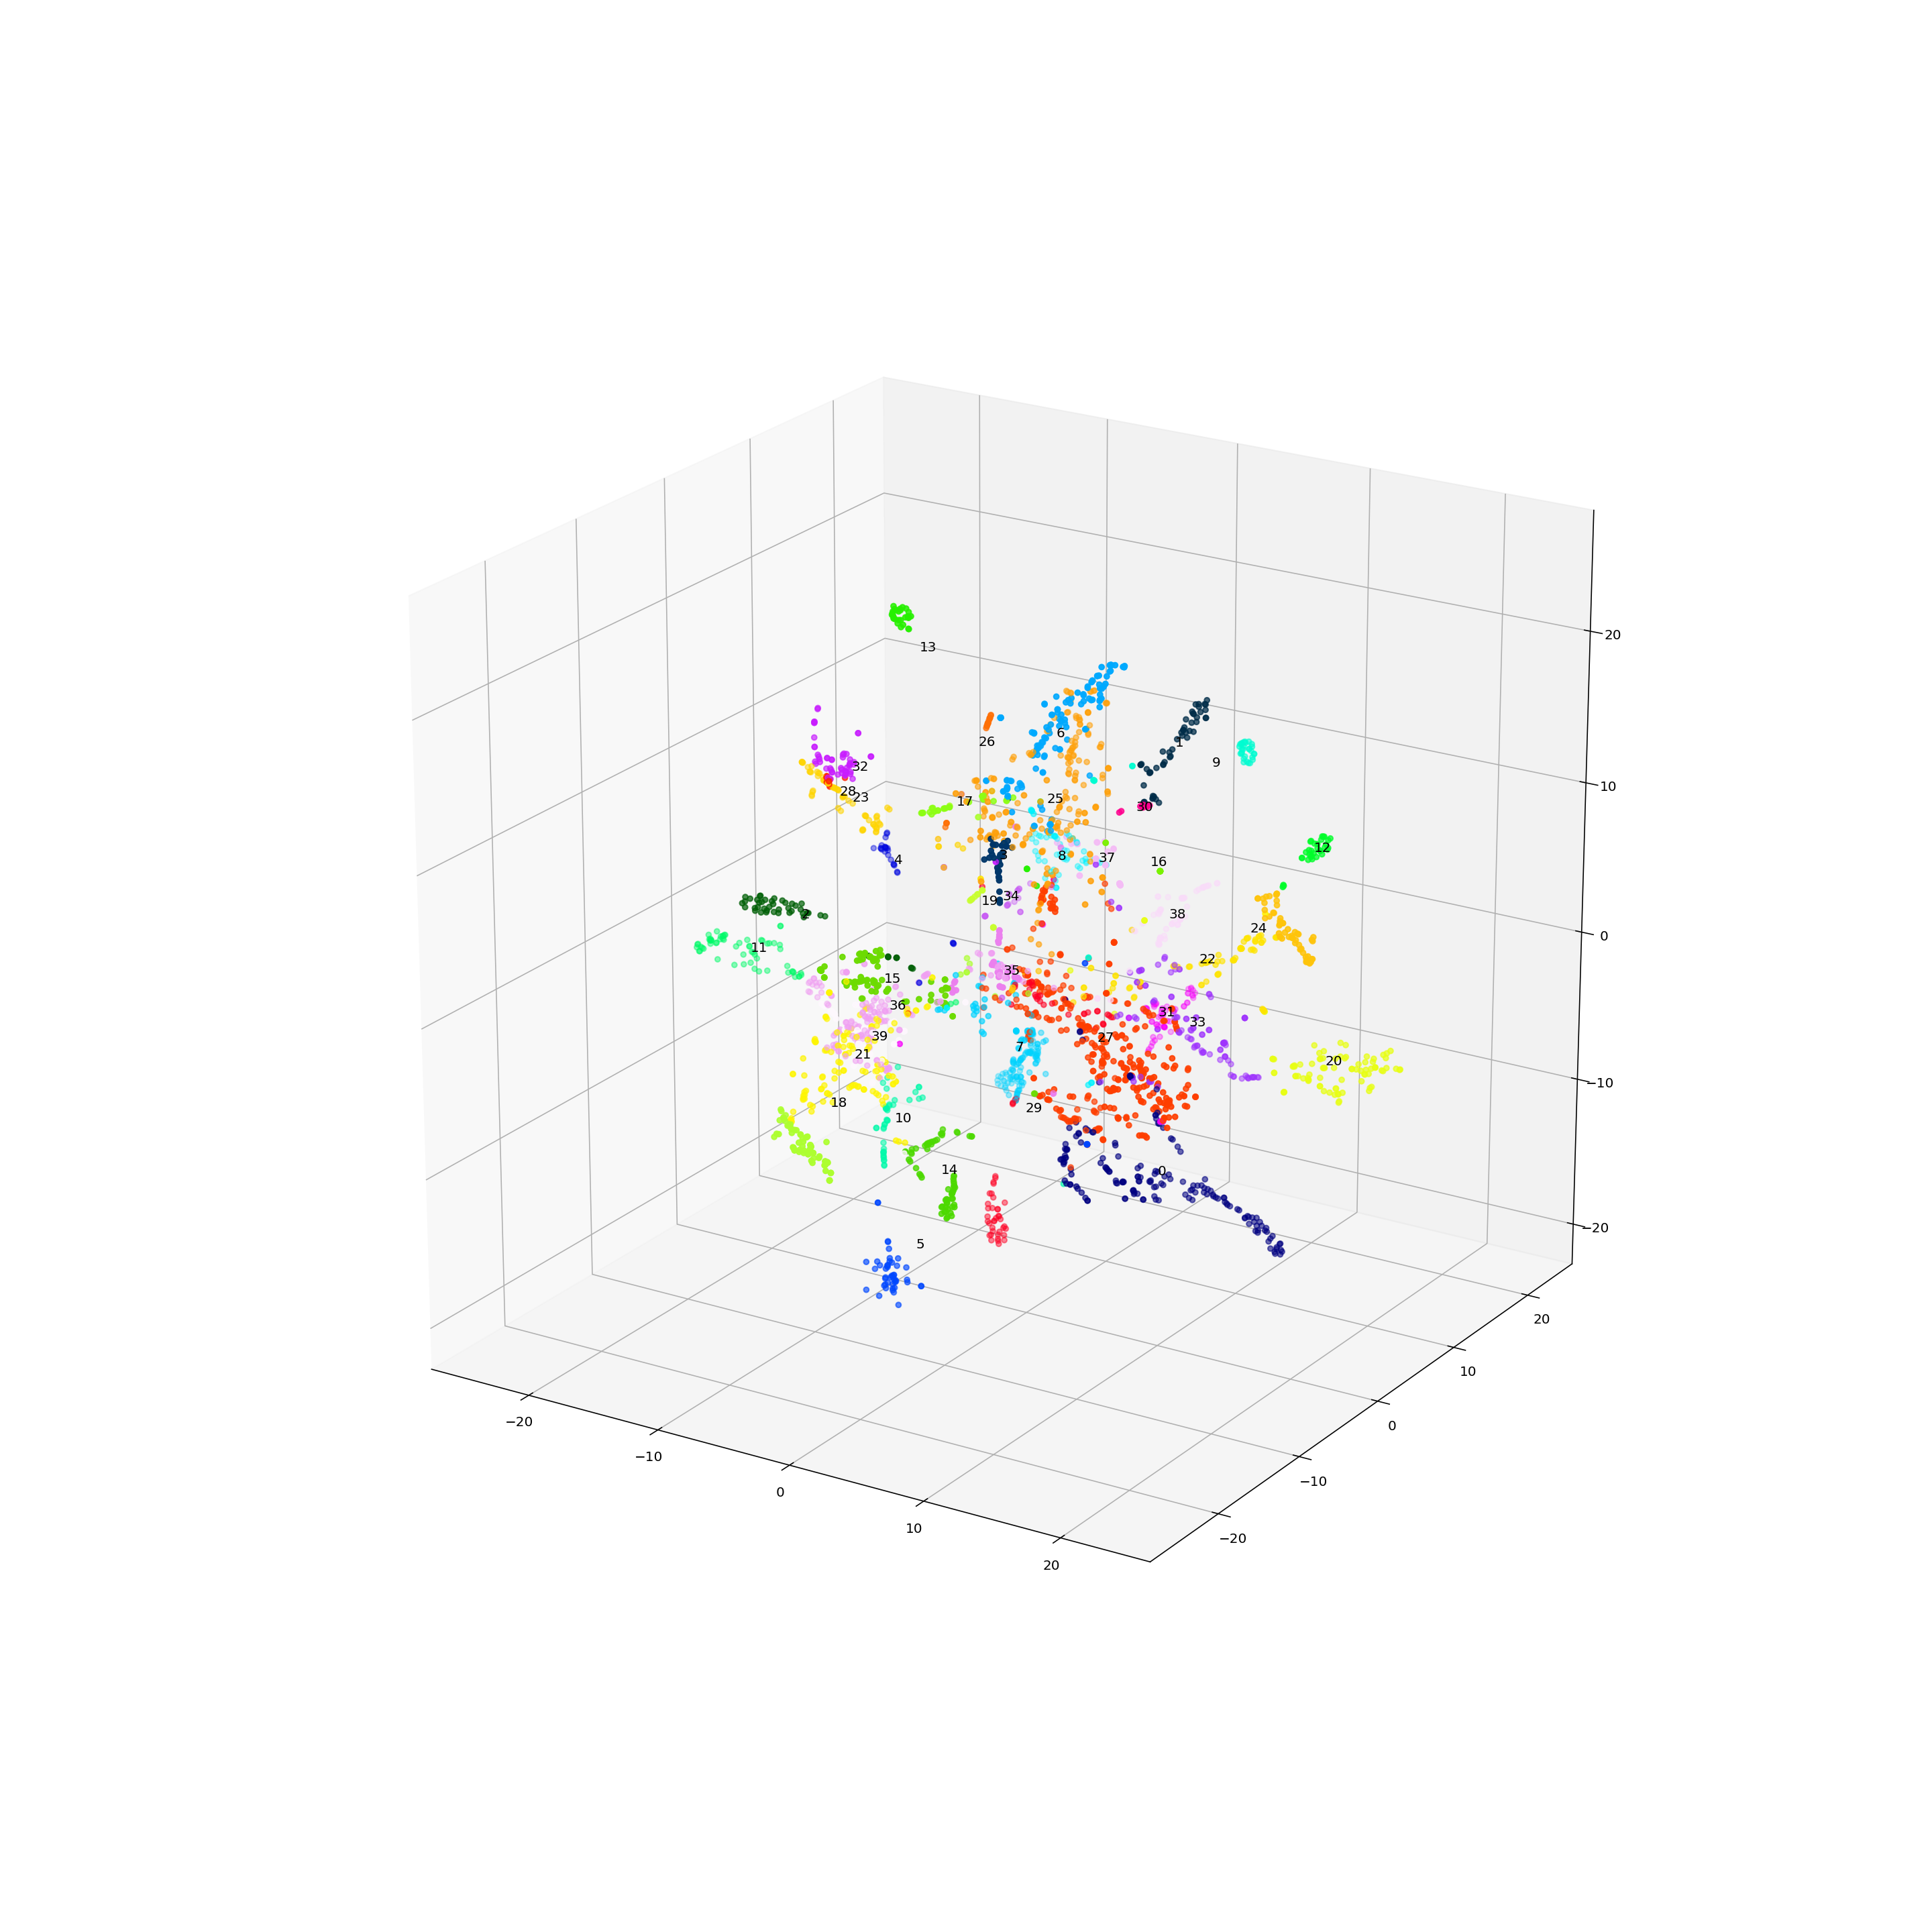

In [227]:
from mpl_toolkits import mplot3d
%matplotlib notebook


fig3d = plt.figure('3d', figsize = (20, 20))
ax = plt.axes(projection='3d')

ax.scatter3D(tsne_embedding['x'], tsne_embedding['y'], tsne_embedding['z'],s=15, c=tsne_embedding['hue'], cmap='gist_ncar')
for i, num in enumerate(topic_numbers):
    ax.text(tsne_centers[i][0], tsne_centers[i][1], tsne_centers[i][2], num)

**Reducing Dimension using SVD**

In [196]:
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
svd_embedding = svd.fit_transform(nmf_embedding)
svd_embedding = pd.DataFrame(svd_embedding,columns=['x','y'])
svd_embedding['hue'] = nmf_embedding.argmax(axis=1)

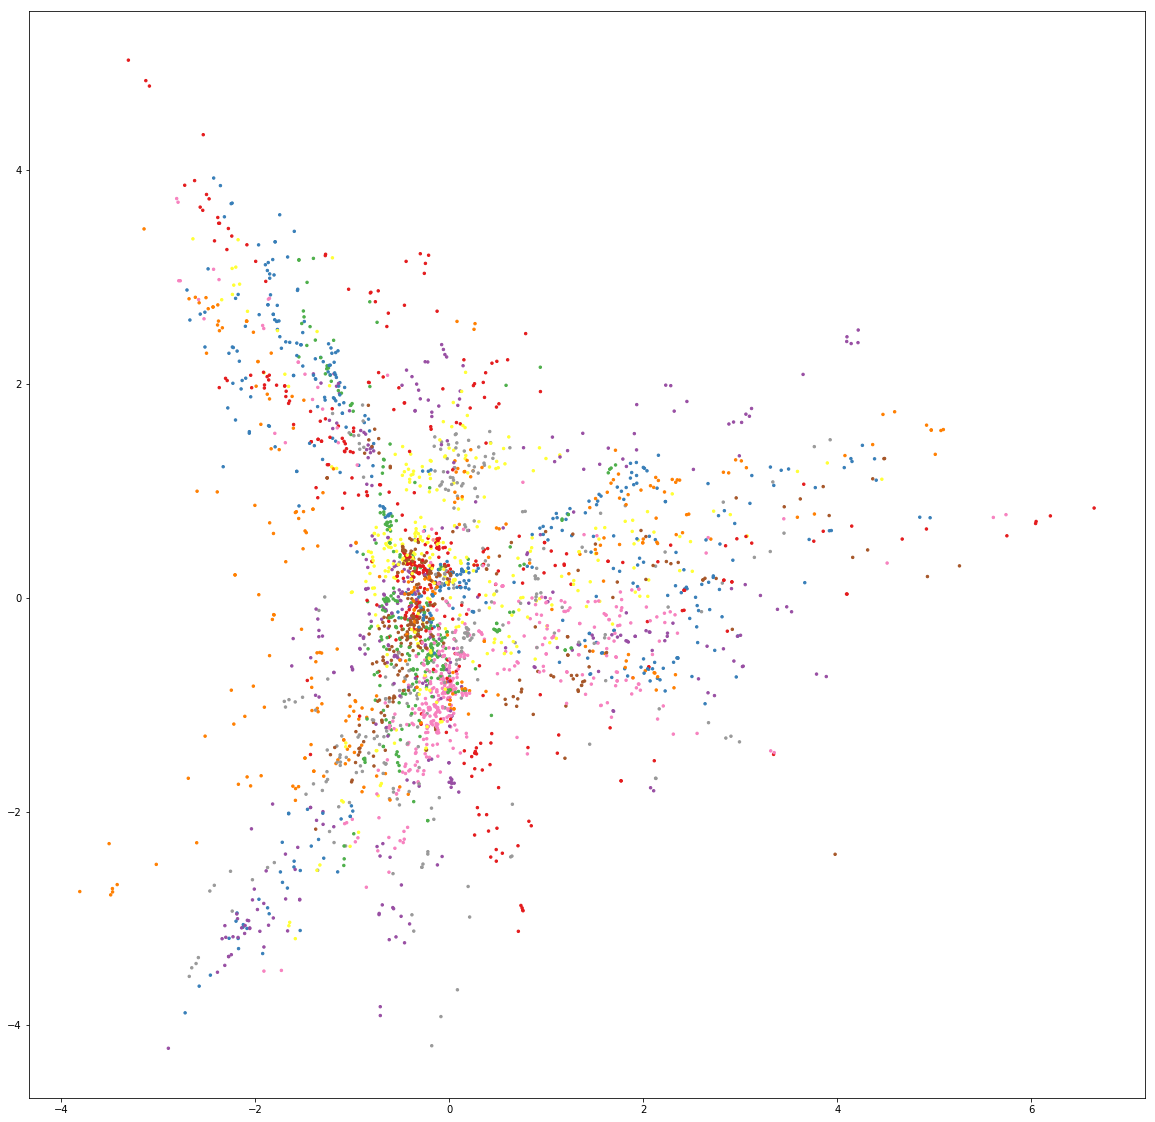

In [197]:
fig2 = plt.figure(figsize=(20, 20))
data = svd_embedding
scatter = plt.scatter(data=data,x='x',y='y',s=6,c=data['hue'],cmap="Set1")

**LDA**

In [119]:
corpus_used = cleaned_corpus

In [120]:
id2word = gensim.corpora.Dictionary(corpus_used);
id2word

In [121]:
bow_corpus = [id2word.doc2bow(doc) for doc in corpus_used]

In [122]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [123]:
num_topics = 100

In [108]:
lda = gensim.models.ldamodel.LdaModel(bow_corpus, num_topics=num_topics, id2word=id2word, passes=5)

/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [124]:
lda_tfidf = gensim.models.ldamodel.LdaModel(corpus_tfidf, num_topics=num_topics, id2word=id2word, passes=5)

/anaconda3/lib/python3.7/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [110]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [103]:
get_lda_topics(lda, num_topics)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,course,course,design,course,use,health,course,course,course,course
1,lesson,performance,fire,group,reading,research,lab,class,lab,work
2,student,class,use,class,writing,development,lecture,student,student,learning
3,project,student,course,lecture,course,course,painting,system,laboratory,student
4,class,demonstrate,create,history,class,lecture,work,exam,class,class
5,instructor,participation,web,social,grammar,management,class,network,use,math
6,may,typical,data,cultural,identify,communication,use,use,lecture,may
7,due,music,lab,wine,text,describe,student,computer,training,lecture
8,unit,lab,basic,explain,may,medical,typical,lecture,body,instructor
9,way,soccer,lecture,political,language,typical,field,information,system,college


In [125]:
get_lda_topics(lda_tfidf, num_topics)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,...,Topic # 91,Topic # 92,Topic # 93,Topic # 94,Topic # 95,Topic # 96,Topic # 97,Topic # 98,Topic # 99,Topic # 100
0,rifle,fire,aie,theater,soccer,religions,apps,riding,nesl,children,...,availablefeasible,conducive,dance,programming,dogs,knife,dsps,astronomy,dropped,shotgun
1,firing,project,tenkey,math,basketball,sculpting,hygiene,recursive,canvas,business,...,lancaster,really,sexual,automotive,axial,trompe,climbing,athletic,demostrate,americans
2,patrol,learning,juice,algebra,game,sikhism,complementary,bicycle,argumentation,child,...,baroque,quantities,poetry,cs,exclude,oeil,click,practicum,epithelial,west
3,targets,writing,treadmills,character,play,commitments,trades,hash,noncredit,medical,...,kenon,songsscenes,quiz,dimensional,explorations,glaze,rock,fillintheblank,enhances,insurance
4,disassembly,instructor,rivera,fiction,dribbling,shinto,tints,liberal,sport,patient,...,renfrow,lots,movement,diagnostic,operates,impasto,leave,taping,elevator,racial
5,unloading,study,ellipticals,acting,shooting,confucianism,industrial,algorithms,dive,care,...,popular,walters,improvisation,engine,outward,glazes,proficiencies,astr,eat,assimilation
6,rounds,reading,bowling,rehearsals,passing,raises,google,cycling,registered,childhood,...,suggestions,seriousness,organic,emissions,sustainment,knives,button,planets,paleogeography,counters
7,zeroing,management,healthier,voice,outdoor,distracting,shades,linked,dives,policy,...,melody,thermodynamic,danc,repair,swaying,glow,hope,mother,payne,segregation
8,marksmanship,research,selfdefense,literature,ball,sp,tones,queues,disabled,psychology,...,alfred,hewitt,makeup,diagnosis,virtualpc,superimposing,ellis,americans,refrain,ethnicity
9,client,lab,posing,performances,firearms,selfmanagement,analogous,stacks,argumentative,email,...,playback,pns,timely,systems,os,burnt,assistive,kin,thinned,ethnic


In [112]:
vis_data =pyLDAvis.gensim.prepare(lda_tfidf, bow_corpus, id2word)
pyLDAvis.display(vis_data)

/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


**HDP**

In [113]:
from gensim.models import HdpModel

In [114]:
def get_hdp_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

In [115]:
hdp = gensim.models.hdpmodel.HdpModel(bow_corpus, id2word=id2word)

In [116]:
hdp_tfidf = gensim.models.hdpmodel.HdpModel(corpus_tfidf, id2word=id2word)

In [72]:
get_hdp_topics(hdp, 10)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,course,course,course,course,course,course,course,statistics,intercollegiate,anthology
1,class,use,student,fire,use,class,lab,course,team,ceremony
2,student,student,class,class,color,student,math,standard,course,literary
3,lecture,lab,lecture,student,lecture,work,class,data,practice,layout
4,work,class,group,lab,class,painting,lecture,probability,competition,magazine
5,fire,work,use,lecture,work,musical,welding,use,class,publication
6,may,design,work,use,student,lecture,use,mean,demonstrate,design
7,typical,lecture,research,typical,lab,theater,testing,distribution,performance,student
8,use,may,typical,may,typical,performance,learning,find,game,course
9,lab,typical,may,demonstrate,identify,typical,algebra,typical,participation,lecture


In [118]:
get_hdp_topics(hdp_tfidf, 15)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15
0,design,fire,grammar,fitness,mestiza,jungle,desire,construction,nervous,horizontal,thirteen,bios,otorhinolaryngology,nekton,echelon
1,web,kin,writing,exercise,professional,skimming,thyroid,vocational,neuroanatomy,aggressively,turnover,withheld,generalist,bathroom,bicarbonate
2,business,swimming,coverage,crowded,softball,wearable,set,handwrist,litigation,deuce,invent,terminology,neuromuscular,preclassic,shirt
3,linear,describe,verb,seven,matchable,categorization,assimilate,fly,tutor,phrase,assemblage,always,psychomotor,overhead,thoracostomy
4,math,wine,encroachment,grand,polo,gift,owl,waltz,synovial,poignantly,eighth,patricide,orthogonality,om,garrison
5,color,child,musical,search,monohybrid,ink,endorsed,nonacademic,nonverbal,typology,triton,atomics,recirculation,causing,dependence
6,learning,dance,tense,rate,permission,intestine,paranoid,osteology,screenplay,dosimetry,slice,lan,chad,constructionist,missing
7,soccer,head,dominant,muscular,volleyball,following,certification,planktonic,meridian,hell,clear,generally,sedative,continue,electrocardiography
8,music,swim,brown,endurance,colored,procrastinate,polarity,departmental,predictably,definitional,internally,internationalization,locomotive,capability,modulation
9,academic,early,ballad,correctly,patternmaker,stereochemical,vat,lukewarm,wearability,agreement,film,infiltration,tangible,spoke,urethra


Hierarchical Dirichlet Process doesn't seem to work very well 